In [2]:
from elasticsearch import Elasticsearch
import pandas as pd
import matplotlib.pyplot as plt
import requests
import numpy as np
from sklearn.linear_model import LinearRegression
from dotenv import load_dotenv
import os

In [3]:
load_dotenv()

es = Elasticsearch(
    "https://localhost:9200",
    basic_auth=(os.environ["ES_USERNAME"], os.environ["ES_PASSWORD"]),
    verify_certs=False,
)

d:\Learning\Cluster and Cloud Computing\A2\.venv\Lib\site-packages\elasticsearch\_sync\client\__init__.py:399: SecurityWarning: Connecting to 'https://127.0.0.1:9200' using TLS with verify_certs=False is insecure
  _transport = transport_class(


In [14]:
def get_rainfall(date):
    url = f"http://localhost:9090/bom-past-rainfall/rainfall/{date}"
    headers = {"X-Fission-Params-Date": date}
    response = requests.get(url, headers=headers)
    j = response.json()
    if j['ok']:
        return j.get('rainfall_amount', 0)
    else:
        return None

In [15]:
def get_accident_count(date):
    url = f"http://localhost:9090/traffic-accident/accident-count/{date}"
    headers = {"X-Fission-Params-Date": date}
    response = requests.get(url, headers=headers)
    j = response.json()
    if j['ok']:
        return j.get('center_accidents', 0)
    else:
        return None

In [16]:
# create a dataframe for storing the accident data and rainfall data
accident_data = []
rainfall_data = []
# set date range from 2023-04-01 to 2023-09-30
date_range = pd.date_range(start="2023-04-01", end="2023-09-30")

for date in date_range:
    date_str = date.strftime("%Y-%m-%d")
    accident_count = get_accident_count(date_str)
    rainfall = get_rainfall(date_str)
    accident_data.append({"Date": date, "Accident Count": accident_count})
    rainfall_data.append({"Date": date, "Rainfall (mm)": rainfall})

accident_df = pd.DataFrame(accident_data)
rainfall_df = pd.DataFrame(rainfall_data)

# set date as the index
accident_df.set_index("Date", inplace=True)
rainfall_df.set_index("Date", inplace=True)

print(accident_df.head())
print(rainfall_df.head())

            Accident Count
Date                      
2023-04-01              13
2023-04-02              12
2023-04-03              12
2023-04-04              12
2023-04-05               9
            Rainfall (mm)
Date                     
2023-04-01            4.6
2023-04-02            0.2
2023-04-03            0.0
2023-04-04            0.0
2023-04-05            0.0


            Rainfall (mm)  Accident Count
Date                                     
2023-04-01            4.6              13
2023-04-02            0.2              12
2023-04-03            0.0              12
2023-04-04            0.0              12
2023-04-05            0.0               9


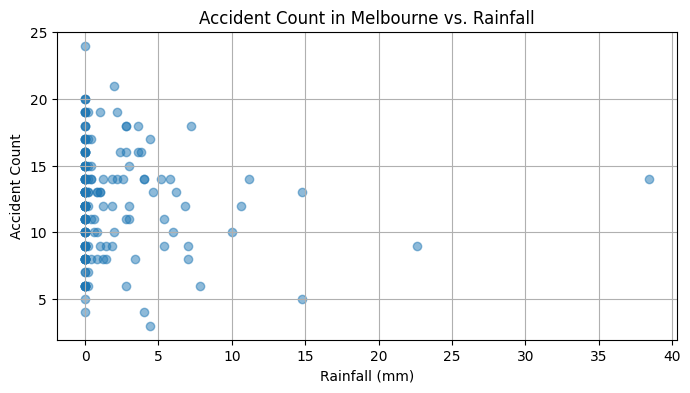

In [22]:
# merge weather rainfall data and accident data
combined_df = pd.merge(rainfall_df, accident_df, left_index=True, right_index=True)
print(combined_df.head())

# scatter plot
plt.figure(figsize=(8, 4))
plt.scatter(combined_df["Rainfall (mm)"], combined_df["Accident Count"], alpha=0.5)

# draw a best fit line
# X = combined_df['Rainfall (mm)'].values.reshape(-1, 1)
# y = combined_df['Accident Count'].values

# model = LinearRegression()
# model.fit(X, y)
# best_fit_line = model.predict(X)
# plt.plot(combined_df['Rainfall (mm)'], best_fit_line, color='red', label='Best fit line')

plt.title("Accident Count in Melbourne vs. Rainfall")
plt.xlabel("Rainfall (mm)")
plt.ylabel("Accident Count")
plt.grid(True)
plt.show()

In [8]:
from datetime import datetime, timedelta


def get_avg_temp(date: datetime) -> float:
    resp = requests.get(
        f"http://127.0.0.1:9090/bom-real-time/avg-day-temp/{date.strftime('%Y-%m-%d')}"
    )
    resp_json = resp.json()
    assert resp_json["ok"]
    return resp_json["avg_temp"]


yesterday = datetime.now().replace(
    hour=0, minute=0, second=0, microsecond=0
) - timedelta(days=1)
avg_temps = []
for i in range(5):
    d = yesterday - timedelta(days=i)
    d_str = d.strftime("%Y-%m-%d")
    avg_temps.append(get_avg_temp(d))
avg_temps.reverse()
avg_temps

[13.43541666666667,
 11.120833333333332,
 11.280434782608696,
 11.585416666666667,
 10.289361702127657]

In [9]:
def get_num_toots(date: datetime) -> int:
    resp = requests.get(
        f"http://127.0.0.1:9090/get-num-toots-by-date/{date.strftime('%Y-%m-%d')}"
    )
    resp_json = resp.json()
    assert resp_json["ok"]
    return resp_json["num_of_toots"]


num_toots = []
for i in range(5):
    d = yesterday - timedelta(days=i)
    num_toots.append(get_num_toots(d))
num_toots.reverse()
num_toots

[19, 22, 21, 24, 13]

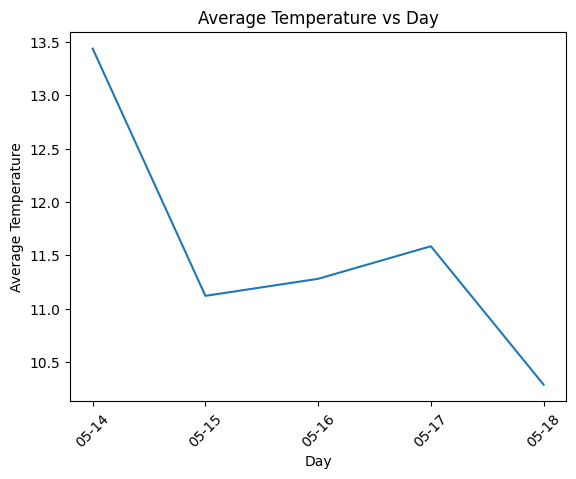

In [10]:
import seaborn as sns

days = [(yesterday - timedelta(days=i)).strftime("%m-%d") for i in range(5)]
days.reverse()
sns.lineplot(x=days, y=avg_temps)
plt.title("Average Temperature vs Day")
plt.xlabel("Day")
plt.ylabel("Average Temperature")
plt.xticks(rotation=45)
plt.show()

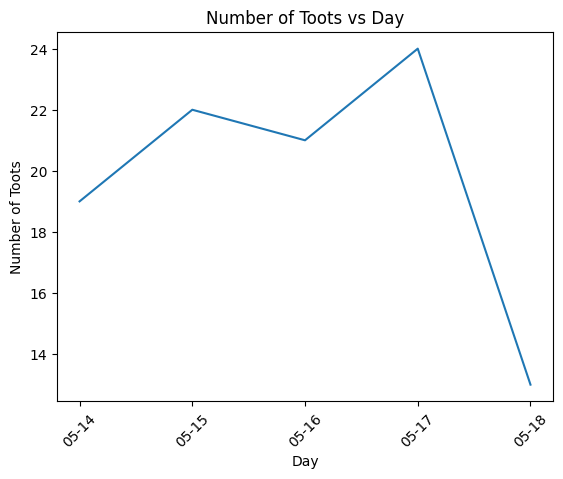

In [11]:
sns.lineplot(x=days, y=num_toots)
plt.title("Number of Toots vs Day")
plt.xlabel("Day")
plt.ylabel("Number of Toots")
plt.xticks(rotation=45)
plt.show()

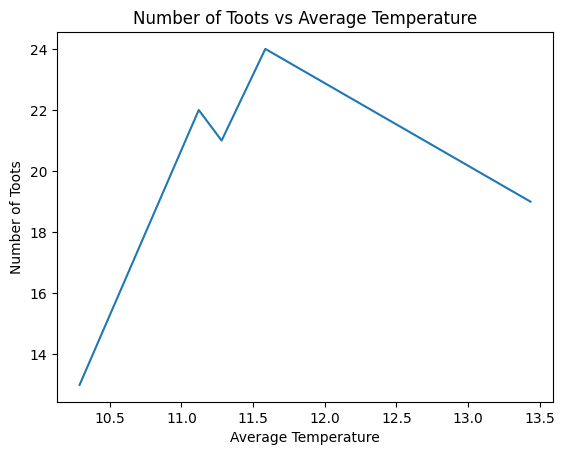

In [12]:
sns.lineplot(x=avg_temps, y=num_toots)
plt.title("Number of Toots vs Average Temperature")
plt.xlabel("Average Temperature")
plt.ylabel("Number of Toots")
plt.show()